# UCI HAR Dataset - Human Activity Recognition

## Authors
- **t8220170**
- **t8220022**

## Dataset Overview

This notebook explores the **Human Activity Recognition (HAR) Using Smartphones Dataset** from UCI Machine Learning Repository.

### Key Information:
- **Purpose**: Classify human activities using smartphone sensor data
- **Subjects**: 30 volunteers (ages 19-48)
- **Activities**: 6 different activities
- **Sensors**: Accelerometer and Gyroscope (3-axial)
- **Sampling Rate**: 50 Hz
- **Window Size**: 2.56 seconds (128 readings per window)
- **Features**: 561 time and frequency domain features

## Dataset Structure

The dataset contains:
- **Features**: 561 normalized features (bounded within [-1, 1])
- **Labels**: Activity labels (1-6)

### Activities:
1. WALKING
2. WALKING_UPSTAIRS
3. WALKING_DOWNSTAIRS
4. SITTING
5. STANDING
6. LAYING

In [1]:
from sklearn.datasets import fetch_openml
import pandas as pd
import numpy as np

In [2]:

X, y = fetch_openml(
    name="har",
    version=1,
    return_X_y=True,
    as_frame=True
)

print(X.shape)
print(y.value_counts())


(10299, 561)
Class
6    1944
5    1906
4    1777
1    1722
2    1544
3    1406
Name: count, dtype: int64


In [3]:
X.dtypes.value_counts()

float64    561
Name: count, dtype: int64

In [4]:
df_counts = X.agg(
    ['min','max']
)
df_counts

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V552,V553,V554,V555,V556,V557,V558,V559,V560,V561
min,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
max,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [5]:
len(X)

10299

## Summary

### Dataset Characteristics:
- **Total Samples**: 10,299
- **Features**: 561 normalized features from accelerometer and gyroscope sensors
- **Activities**: 6 different human activities
- **Data Quality**: No missing values, all features normalized to [-1, 1]

### Key Observations:
- The dataset is relatively balanced across activities
- Features are extracted from both time and frequency domains
- Data is pre-processed and normalized

This dataset is well-suited for classification tasks to recognize human activities from smartphone sensor data.

In [6]:
from sklearn.model_selection import train_test_split

X_train_unnormalized, X_test_unnormalized, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
import numpy as np

def fit_standardizer(X_train_unnormalized):
    mu = X_train_unnormalized.mean(axis=0)
    sigma = X_train_unnormalized.std(axis=0, ddof=0)
    sigma = np.where(sigma == 0, 1.0, sigma)
    return mu, sigma

def transform_standardizer(X, mu, sigma):
    return (X - mu) / sigma


In [8]:
mu, sigma = fit_standardizer(X_train_unnormalized)
X_train = transform_standardizer(X_train_unnormalized, mu, sigma)
X_test  = transform_standardizer(X_test_unnormalized,  mu, sigma)

## Helpers

In [11]:
import numpy as np

def make_one_hot(y, classes):

    idx = {c:i for i,c in enumerate(classes)}
    y_idx = np.array([idx[v] for v in y], dtype=int)

    Y = np.zeros((y_idx.size, len(classes)), dtype=float)
    Y[np.arange(y_idx.size), y_idx] = 1.0
    return Y, y_idx

In [12]:
def softmax(Z: np.ndarray) -> np.ndarray:
    Z = Z - Z.max(axis=1, keepdims=True)
    expZ = np.exp(Z)
    return expZ / expZ.sum(axis=1, keepdims=True)

def cross_entropy(P: np.ndarray, Y: np.ndarray, eps: float = 1e-12) -> float:
    P = np.clip(P, eps, 1.0)
    return float(-(Y * np.log(P)).sum(axis=1).mean())

def classification_report(y_true, y_pred, labels=None):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)

    if labels is None:
        labels = np.unique(np.concatenate([y_true, y_pred]))
    else:
        labels = np.asarray(labels)

    report = {}
    report['classes'] = {}

    accuracy = (y_true == y_pred).mean()

    precision_sum = 0.0
    recall_sum = 0.0
    f1_sum = 0.0
    total_support = len(y_true)

    for label in labels:
        tp = np.sum((y_pred == label) & (y_true == label))
        fp = np.sum((y_pred == label) & (y_true != label))
        fn = np.sum((y_true == label) & (y_pred != label))
        support = np.sum(y_true == label)

        precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0

        recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0

        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0

        report['classes'][label] = {
            'precision': precision,
            'recall': recall,
            'f1-score': f1,
            'support': support
        }

        precision_sum += precision
        recall_sum += recall
        f1_sum += f1

    n_classes = len(labels)
    report['macro_avg'] = {
        'precision': precision_sum / n_classes,
        'recall': recall_sum / n_classes,
        'f1-score': f1_sum / n_classes,
        'support': total_support
    }
    weighted_precision = sum(report['classes'][label]['precision'] * report['classes'][label]['support']
                            for label in labels) / total_support
    weighted_recall = sum(report['classes'][label]['recall'] * report['classes'][label]['support']
                         for label in labels) / total_support
    weighted_f1 = sum(report['classes'][label]['f1-score'] * report['classes'][label]['support']
                     for label in labels) / total_support

    report['weighted_avg'] = {
        'precision': weighted_precision,
        'recall': weighted_recall,
        'f1-score': weighted_f1,
        'support': total_support
    }

    report['accuracy'] = accuracy

    return report

def print_classification_report(y_true, y_pred, labels=None, digits=4):
    report = classification_report(y_true, y_pred, labels)

    print(f"{'':<15} {'precision':<12} {'recall':<12} {'f1-score':<12} {'support':<12}")
    print("-" * 65)

    for label in sorted(report['classes'].keys()):
        metrics = report['classes'][label]
        print(f"{str(label):<15} {metrics['precision']:<12.{digits}f} {metrics['recall']:<12.{digits}f} "
              f"{metrics['f1-score']:<12.{digits}f} {int(metrics['support']):<12}")

    print("-" * 65)

    macro = report['macro_avg']
    print(f"{'macro avg':<15} {macro['precision']:<12.{digits}f} {macro['recall']:<12.{digits}f} "
          f"{macro['f1-score']:<12.{digits}f} {int(macro['support']):<12}")

    weighted = report['weighted_avg']
    print(f"{'weighted avg':<15} {weighted['precision']:<12.{digits}f} {weighted['recall']:<12.{digits}f} "
          f"{weighted['f1-score']:<12.{digits}f} {int(weighted['support']):<12}")

    print("-" * 65)

    print(f"{'accuracy':<15} {report['accuracy']:<12.{digits}f} {int(report['weighted_avg']['support']):<12}")
    print()

In [13]:
from abc import ABC, abstractmethod

class BaseModel(ABC):
    @abstractmethod
    def fit(self, X_train, y_train):
        pass

    @abstractmethod
    def predict(self, X):
        pass

In [28]:
def fit_sklearn_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred_test = model.predict(X_test)
    y_pred_train = model.predict(X_train)

    acc_test = (y_pred_test == np.asarray(y_test)).mean()
    acc_train = (y_pred_train == np.asarray(y_train)).mean()
    
    print("Train accuracy:" ,  acc_train)
    print("Test Accuracy:", acc_test)
    print("\nClassification Report:")
    print_classification_report(y_test, y_pred_test)

## PCA

In [15]:
class PCA(BaseModel):
    def __init__(self, n_components: int):
        self.n_components = n_components
        self.mean_ = None
        self.components_ = None
        self.explained_variance_ = None

    def fit(self, X: np.ndarray):
        """
        Fit PCA on data X.

        Parameters
        X : np.ndarray of shape (n_samples, n_features)
        """
        self.mean_ = np.mean(X, axis=0)
        X_centered = X - self.mean_

        # 2. Compute covariance matrix
        cov = np.cov(X_centered, rowvar=False)

        # 3. Eigen decomposition
        eigenvalues, eigenvectors = np.linalg.eigh(cov)

        # 4. Sort eigenvalues & eigenvectors (descending)
        idx = np.argsort(eigenvalues)[::-1]
        eigenvalues = eigenvalues[idx]
        eigenvectors = eigenvectors[:, idx]

        # 5. Select top components
        self.components_ = eigenvectors[:, :self.n_components]
        self.explained_variance_ = eigenvalues[:self.n_components]

        return self

    def predict(self, X: np.ndarray) -> np.ndarray:
        """
        Project data onto principal components.
        """
        if self.components_ is None:
            raise ValueError("PCA has not been fitted yet.")

        X_centered = X - self.mean_
        return X_centered @ self.components_


In [16]:
k = 2
pca = PCA(n_components=k)
pca.fit(X_train)

T_train = pca.predict(X_train)
T_test = pca.predict(X_test)

print(f"PCA components shape: {pca.components_.shape}")
print(f"Cumulative explained variance (k={k}): {pca.explained_variance_.sum():.3f}")


PCA components shape: (561, 2)
Cumulative explained variance (k=2): 319.874


In [17]:
T_train_np = np.asarray(T_train)
y_train_np = np.asarray(y_train)

T_test_np = np.asarray(T_test)
y_test_np = np.asarray(y_test)

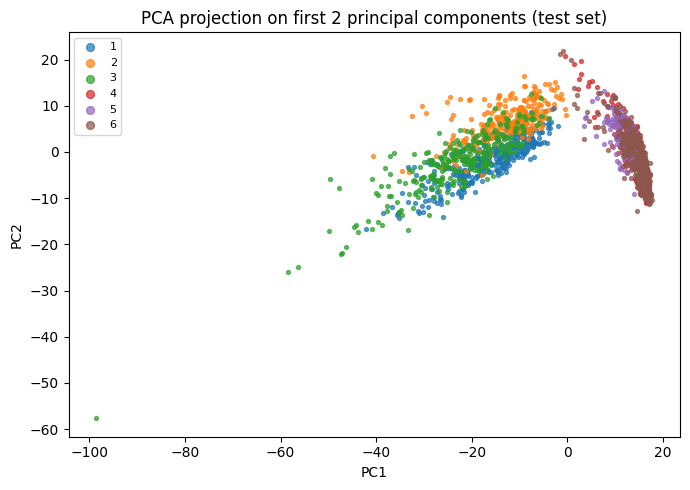

In [18]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(7, 5))

labels = np.unique(y_test)

for lab in labels:
    idx = (y_test == lab)
    plt.scatter(
        T_test_np[idx, 0],
        T_test_np[idx, 1],
        s=8,
        alpha=0.7,
        label=lab
    )

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA projection on first 2 principal components (test set)")
plt.legend(markerscale=2, fontsize=8)
plt.tight_layout()
plt.show()


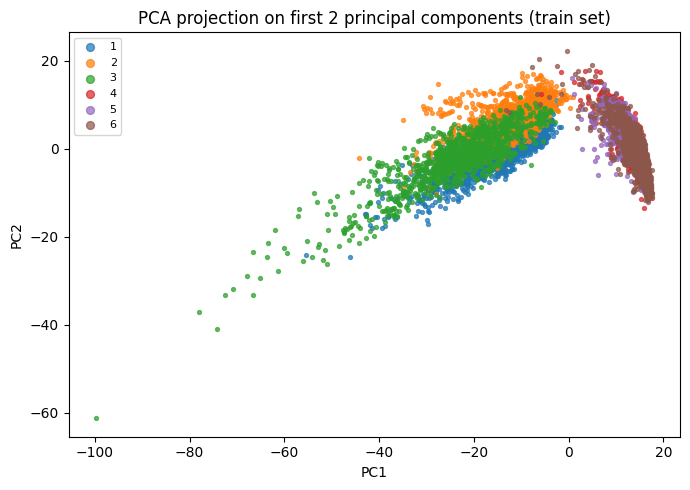

In [19]:
plt.figure(figsize=(7, 5))

labels = np.unique(y_train)

for lab in labels:
    idx = (y_train == lab)
    plt.scatter(
        T_train_np[idx, 0],
        T_train_np[idx, 1],
        s=8,
        alpha=0.7,
        label=lab
    )

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA projection on first 2 principal components (train set)")
plt.legend(markerscale=2, fontsize=8)
plt.tight_layout()
plt.show()


In [20]:
from sklearn.decomposition import PCA as SK_PCA

sklearn_pca = SK_PCA(n_components=2)
sklearn_pca.fit(X_train)


PCA(n_components=2)

In [21]:
print(sklearn_pca.explained_variance_ratio_)

[0.5075262  0.06258965]


In [22]:
T_train = sklearn_pca.transform(X_train)
T_test = sklearn_pca.transform(X_test)


In [23]:
T_train_np = np.asarray(T_train)
y_train_np = np.asarray(y_train)

T_test_np = np.asarray(T_test)
y_test_np = np.asarray(y_test)

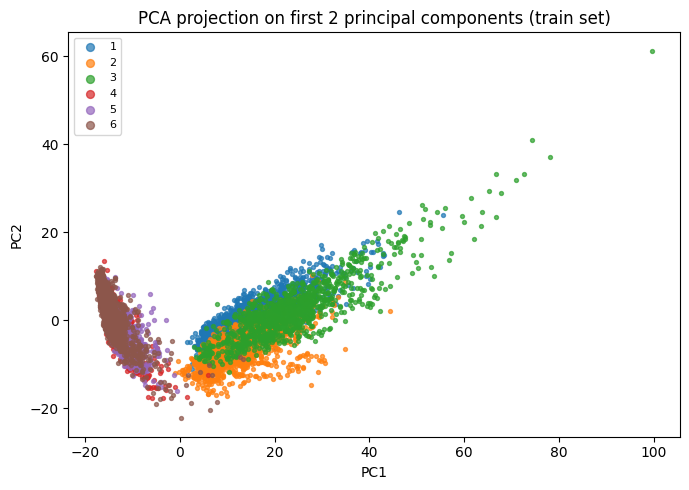

In [24]:
plt.figure(figsize=(7, 5))

labels = np.unique(y_train)

for lab in labels:
    idx = (y_train== lab)
    plt.scatter(
        T_train_np[idx, 0],
        T_train_np[idx, 1],
        s=8,
        alpha=0.7,
        label=lab
    )

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA projection on first 2 principal components (train set)")
plt.legend(markerscale=2, fontsize=8)
plt.tight_layout()
plt.show()

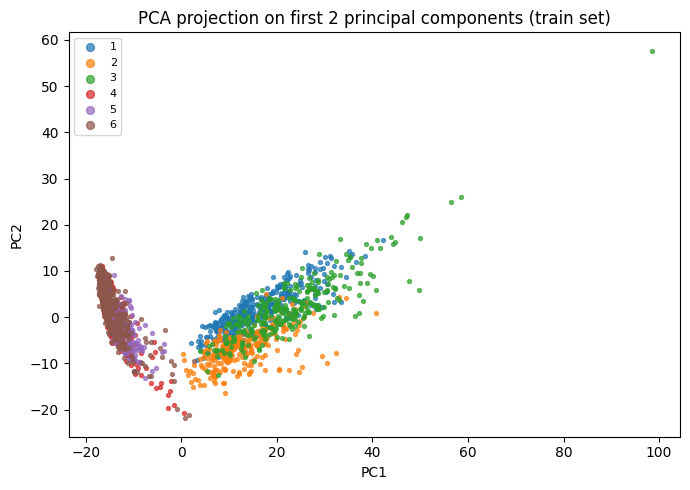

In [25]:
plt.figure(figsize=(7, 5))

labels = np.unique(y_test)

for lab in labels:
    idx = (y_test == lab)
    plt.scatter(
        T_test_np[idx, 0],
        T_test_np[idx, 1],
        s=8,
        alpha=0.7,
        label=lab
    )

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA projection on first 2 principal components (train set)")
plt.legend(markerscale=2, fontsize=8)
plt.tight_layout()
plt.show()


## Least Squares Classifier

In [26]:
class LeastSquaresClassifier(BaseModel):

    def __init__(self, lam=1e-2, add_bias=True):
        self.lam = lam
        self.add_bias = add_bias
        self.W = None
        self.classes = None

    def fit(self, X_train, y_train):
        X = np.asarray(X_train, dtype=float)
        y = np.asarray(y_train)

        self.classes = np.unique(y)
        Y, _ = make_one_hot(y, self.classes)

        if self.add_bias:
            X = np.c_[np.ones((X.shape[0], 1)), X]

        d = X.shape[1]
        A = X.T @ X + self.lam * np.eye(d)
        B = X.T @ Y

        self.W = np.linalg.solve(A, B)
        return self

    def predict(self, X):
        X = np.asarray(X, dtype=float)
        if self.add_bias:
            X = np.c_[np.ones((X.shape[0], 1)), X]

        scores = X @ self.W
        pred_idx = np.argmax(scores, axis=1)
        return self.classes[pred_idx]


In [32]:
model = LeastSquaresClassifier(lam=1e-2)
model.fit(X_train, y_train)

y_pred_test = model.predict(X_test)
y_pred_train = model.predict(X_train)

acc_train = (y_pred_train == np.asarray(y_train)).mean()
acc_test = (y_pred_test == np.asarray(y_test)).mean()
print("Train accuracy:" ,  acc_train)
print("Test Accuracy:", acc_test)
print("\nClassification Report:")
print_classification_report(y_test, y_pred_test)

Train accuracy: 0.9832503944653478
Test Accuracy: 0.9752427184466019

Classification Report:
                precision    recall       f1-score     support     
-----------------------------------------------------------------
1               0.9973       0.9973       0.9973       369         
2               0.9853       0.9963       0.9908       270         
3               1.0000       0.9965       0.9982       284         
4               0.9434       0.9284       0.9358       377         
5               0.9380       0.9407       0.9394       354         
6               0.9927       1.0000       0.9963       406         
-----------------------------------------------------------------
macro avg       0.9761       0.9765       0.9763       2060        
weighted avg    0.9751       0.9752       0.9752       2060        
-----------------------------------------------------------------
accuracy        0.9752       2060        



In [30]:
from sklearn.linear_model import RidgeClassifier as SK_RidgeClassifier

clf = SK_RidgeClassifier(alpha=1e-2)
fit_sklearn_model(clf, X_train, y_train, X_test, y_test)

Train accuracy: 0.9832503944653478
Test Accuracy: 0.9752427184466019

Classification Report:
                precision    recall       f1-score     support     
-----------------------------------------------------------------
1               0.9973       0.9973       0.9973       369         
2               0.9853       0.9963       0.9908       270         
3               1.0000       0.9965       0.9982       284         
4               0.9434       0.9284       0.9358       377         
5               0.9380       0.9407       0.9394       354         
6               0.9927       1.0000       0.9963       406         
-----------------------------------------------------------------
macro avg       0.9761       0.9765       0.9763       2060        
weighted avg    0.9751       0.9752       0.9752       2060        
-----------------------------------------------------------------
accuracy        0.9752       2060        



## Softmax Logistic Regression

In [33]:
def one_hot_from_indices(y_idx: np.ndarray, C: int) -> np.ndarray:
    Y = np.zeros((y_idx.size, C), dtype=float)
    Y[np.arange(y_idx.size), y_idx] = 1.0
    return Y


class LogisticRegression(BaseModel):

    def __init__(self, lr=0.05, epochs=20, batch_size=128, lam=0.0, seed=42):
        self.lr = lr
        self.epochs = epochs
        self.batch_size = batch_size
        self.lam = lam
        self.seed = seed
        self.W = None
        self.b = None
        self.classes = None
        self.history = None



    def fit(self, X_train, y_train, X_test, y_test):
        X = np.asarray(X_train, dtype=float)
        y = np.asarray(y_train)

        self.classes = np.unique(y)
        C = self.classes.size
        class_to_idx = {c: i for i, c in enumerate(self.classes)}
        y_idx = np.array([class_to_idx[v] for v in y], dtype=int)

        X_test_arr = np.asarray(X_test, dtype=float)
        y_test_arr = np.asarray(y_test)
        y_test_idx = np.array([class_to_idx[v] for v in y_test_arr], dtype=int)
        Y_test = one_hot_from_indices(y_test_idx, C)

        n, d = X.shape
        rng = np.random.default_rng(self.seed)

        self.W = rng.normal(loc=0.0, scale=0.01, size=(C, d))
        self.b = np.zeros(C, dtype=float)

        self.history = {"loss": [], "test_loss": []}

        for epoch in range(1, self.epochs + 1):
            perm = rng.permutation(n)
            Xs = X[perm]
            ys = y_idx[perm]

            epoch_loss = 0.0
            n_batches = 0

            for start in range(0, n, self.batch_size):
                end = min(start + self.batch_size, n)
                Xb = Xs[start:end]
                yb = ys[start:end]
                Yb = one_hot_from_indices(yb, C)

                Z = Xb @ self.W.T + self.b
                P = softmax(Z)

                batch_loss = cross_entropy(P, Yb)
                epoch_loss += batch_loss
                n_batches += 1

                B = Xb.shape[0]
                G = (P - Yb) / B
                dW = G.T @ Xb
                db = G.sum(axis=0)

                if self.lam > 0:
                    dW += self.lam * self.W

                self.W -= self.lr * dW
                self.b -= self.lr * db

            self.history["loss"].append(epoch_loss / n_batches)

            Z_test = X_test_arr @ self.W.T + self.b
            P_test = softmax(Z_test)
            test_loss = cross_entropy(P_test, Y_test)
            self.history["test_loss"].append(test_loss)

        return self

    def predict(self, X):
        X = np.asarray(X, dtype=float)
        P = softmax(X @ self.W.T + self.b)
        pred_idx = np.argmax(P, axis=1)
        return self.classes[pred_idx]


Train accuracy: 0.9790023061051099
Test Accuracy: 0.9694174757281553
Last train loss: 0.07568248883209706
Last test loss: 0.09099516924947282

Classification Report:
                precision    recall       f1-score     support     
-----------------------------------------------------------------
1               0.9919       0.9919       0.9919       369         
2               0.9851       0.9815       0.9833       270         
3               0.9825       0.9894       0.9860       284         
4               0.9288       0.9337       0.9312       377         
5               0.9343       0.9237       0.9290       354         
6               0.9975       1.0000       0.9988       406         
-----------------------------------------------------------------
macro avg       0.9700       0.9700       0.9700       2060        
weighted avg    0.9694       0.9694       0.9694       2060        
-----------------------------------------------------------------
accuracy        0.9694  

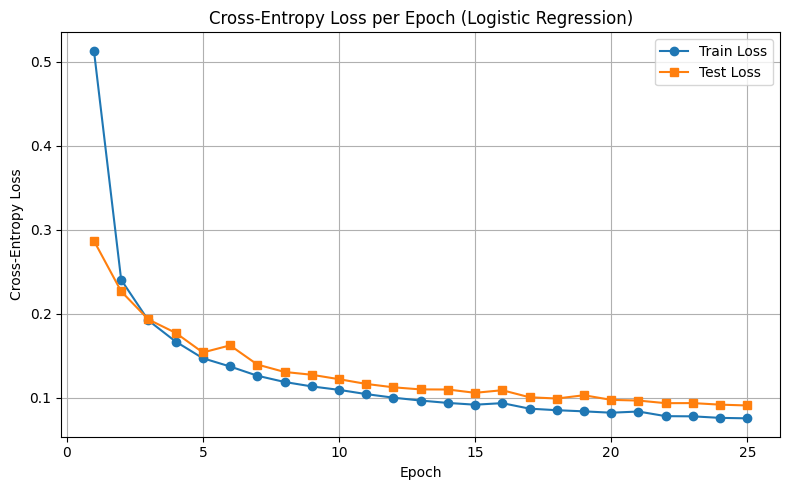

In [36]:
model = LogisticRegression(lr=0.05, epochs=25, batch_size=256, lam=1e-4)
model.fit(X_train, y_train, X_test, y_test)

y_pred_test = model.predict(X_test)
y_pred_train = model.predict(X_train)

acc_train = (y_pred_train == np.asarray(y_train)).mean()
acc_test = (y_pred_test == np.asarray(y_test)).mean()
print("Train accuracy:" ,  acc_train)
print("Test Accuracy:", acc_test)
print("Last train loss:", model.history["loss"][-1])
print("Last test loss:", model.history["test_loss"][-1])
print("\nClassification Report:")
print_classification_report(y_test, y_pred_test)

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
epochs = range(1, len(model.history["loss"]) + 1)
plt.plot(epochs, model.history["loss"], label="Train Loss", marker="o")
plt.plot(epochs, model.history["test_loss"], label="Test Loss", marker="s")
plt.xlabel("Epoch")
plt.ylabel("Cross-Entropy Loss")
plt.title("Cross-Entropy Loss per Epoch (Logistic Regression)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [37]:
from sklearn.linear_model import LogisticRegression as SK_LogisticRegression
fit_sklearn_model(SK_LogisticRegression(penalty="l2", max_iter=25), X_train, y_train, X_test, y_test)

Train accuracy: 0.9853137516688919
Test Accuracy: 0.9742718446601941

Classification Report:
                precision    recall       f1-score     support     
-----------------------------------------------------------------
1               0.9919       0.9919       0.9919       369         
2               0.9888       0.9852       0.9870       270         
3               0.9860       0.9894       0.9877       284         
4               0.9441       0.9416       0.9429       377         
5               0.9380       0.9407       0.9394       354         
6               1.0000       1.0000       1.0000       406         
-----------------------------------------------------------------
macro avg       0.9748       0.9748       0.9748       2060        
weighted avg    0.9743       0.9743       0.9743       2060        
-----------------------------------------------------------------
accuracy        0.9743       2060        



c:\Users\anton\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## KNN

In [69]:
class KNNClassifier(BaseModel):

    def __init__(self, k=1):
        self.k = k
        self.X_train = None
        self.y_train = None

    def fit(self, X_train, y_train):
        self.X_train = np.asarray(X_train, dtype=float)
        self.y_train = np.asarray(y_train)
        return self

    def predict(self, X):
        X = np.asarray(X, dtype=float)
        k = int(self.k)
        if k < 1 or k > self.X_train.shape[0]:
            raise ValueError("k must be in [1, n_train]")

        te_norm = np.sum(X**2, axis=1, keepdims=True)
        tr_norm = np.sum(self.X_train**2, axis=1, keepdims=True).T
        d2 = te_norm + tr_norm - 2 * (X @ self.X_train.T)
        d2 = np.maximum(d2, 0.0)

        nn_idx = np.argpartition(d2, kth=k-1, axis=1)[:, :k]

        y_pred = []
        for i in range(nn_idx.shape[0]):
            neigh_labels = self.y_train[nn_idx[i]]
            values, counts = np.unique(neigh_labels, return_counts=True)
            y_pred.append(values[np.argmax(counts)])

        return np.array(y_pred, dtype=self.y_train.dtype)


In [70]:
import numpy as np

def knn_cv_best_k(X_train, y_train, K=10, num_folds=5, seed=10):
    X = np.asarray(X_train, dtype=float)
    y = np.asarray(y_train)
    N = X.shape[0]

    rng = np.random.default_rng(seed)
    perm = rng.permutation(N)
    X = X[perm]
    y = y[perm]

    fold_sizes = np.full(num_folds, N // num_folds, dtype=int)
    fold_sizes[: N % num_folds] += 1

    Xfolds, yfolds = [], []
    start = 0
    for fs in fold_sizes:
        end = start + fs
        Xfolds.append(X[start:end])
        yfolds.append(y[start:end])
        start = end

    mean_val_acc = np.zeros(K)

    for k in range(1, K + 1):
        accs = []
        for j in range(num_folds):
            X_tr = np.vstack([Xfolds[i] for i in range(num_folds) if i != j])
            y_tr = np.concatenate([yfolds[i] for i in range(num_folds) if i != j])
            X_val = Xfolds[j]
            y_val = yfolds[j]

            pred = KNNClassifier(k=k).fit(X_tr, y_tr).predict(X_val)
            accs.append((pred == y_val).mean())

        mean_val_acc[k - 1] = np.mean(accs)
        print(f"k={k:2d} | mean CV accuracy = {mean_val_acc[k-1]:.4f}")

    best_k = int(np.argmax(mean_val_acc) + 1)
    print(f"\nBest k by CV: {best_k} (mean CV acc = {mean_val_acc[best_k-1]:.4f})")
    return best_k, mean_val_acc


k= 1 | mean CV accuracy = 0.9602
k= 2 | mean CV accuracy = 0.9398
k= 3 | mean CV accuracy = 0.9597
k= 4 | mean CV accuracy = 0.9535
k= 5 | mean CV accuracy = 0.9584
k= 6 | mean CV accuracy = 0.9573
k= 7 | mean CV accuracy = 0.9616
k= 8 | mean CV accuracy = 0.9562
k= 9 | mean CV accuracy = 0.9582
k=10 | mean CV accuracy = 0.9559

Best k by CV: 7 (mean CV acc = 0.9616)


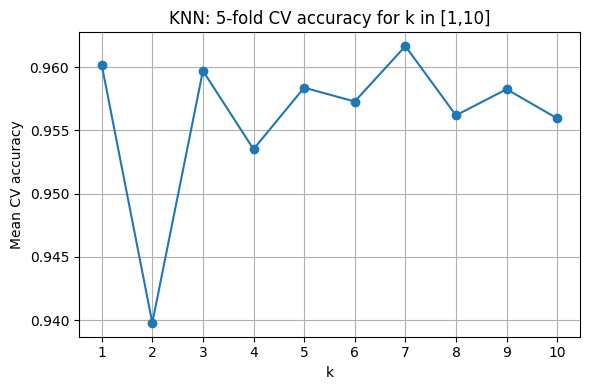

In [71]:
import matplotlib.pyplot as plt

best_k, cv_curve = knn_cv_best_k(X_train, y_train, K=10, num_folds=5, seed=10)

ks = np.arange(1, 11)
plt.figure(figsize=(6,4))
plt.plot(ks, cv_curve, marker="o")
plt.xticks(ks)
plt.xlabel("k")
plt.ylabel("Mean CV accuracy")
plt.title("KNN: 5-fold CV accuracy for k in [1,10]")
plt.grid(True)
plt.tight_layout()
plt.show()


In [72]:
best_knn_model = KNNClassifier(k=best_k).fit(X_train, y_train)
best_knn_pred = best_knn_model.predict(X_test)

acc_train = (best_knn_model.predict(X_train) == np.asarray(y_train)).mean()
acc_test = (best_knn_pred == np.asarray(y_test)).mean()

print(f"\nBest k selected by CV: {best_k}")
print(f"Train accuracy: {acc_train:.4f}")
print(f"Test accuracy:  {acc_test:.4f}")

print("\nClassification Report:")
print_classification_report(y_test, best_knn_pred)



Best k selected by CV: 7
Train accuracy: 0.9765
Test accuracy:  0.9553

Classification Report:
                precision    recall       f1-score     support     
-----------------------------------------------------------------
1               0.9735       0.9946       0.9839       369         
2               0.9743       0.9815       0.9779       270         
3               0.9928       0.9648       0.9786       284         
4               0.9343       0.8674       0.8996       377         
5               0.8711       0.9350       0.9019       354         
6               0.9975       0.9951       0.9963       406         
-----------------------------------------------------------------
macro avg       0.9572       0.9564       0.9564       2060        
weighted avg    0.9562       0.9553       0.9553       2060        
-----------------------------------------------------------------
accuracy        0.9553       2060        



In [73]:
from sklearn.neighbors import KNeighborsClassifier as SK_KNeighborsClassifier
fit_sklearn_model(SK_KNeighborsClassifier(n_neighbors=best_k), X_train, y_train, X_test, y_test)

Train accuracy: 0.9764534530889671
Test Accuracy: 0.9553398058252427

Classification Report:
                precision    recall       f1-score     support     
-----------------------------------------------------------------
1               0.9735       0.9946       0.9839       369         
2               0.9743       0.9815       0.9779       270         
3               0.9928       0.9648       0.9786       284         
4               0.9343       0.8674       0.8996       377         
5               0.8711       0.9350       0.9019       354         
6               0.9975       0.9951       0.9963       406         
-----------------------------------------------------------------
macro avg       0.9572       0.9564       0.9564       2060        
weighted avg    0.9562       0.9553       0.9553       2060        
-----------------------------------------------------------------
accuracy        0.9553       2060        



## Gaussian Naive Bayes Classifier


In [45]:
class GaussianNaiveBayes(BaseModel):

    def __init__(self, eps=1e-9):
        self.eps = eps
        self.priors = None
        self.means = None
        self.class_variances = None
        self.classes = None

    def fit(self, X_train, y_train):
        X = np.asarray(X_train, dtype=float)
        y = np.asarray(y_train)

        self.classes = np.unique(y)
        C = self.classes.size
        n, d = X.shape

        self.priors = np.zeros(C, dtype=float)
        self.means = np.zeros((C, d), dtype=float)
        self.class_variances = np.zeros((C, d), dtype=float)

        for i, c in enumerate(self.classes):
            Xc = X[y == c]
            self.priors[i] = Xc.shape[0] / n
            self.means[i] = Xc.mean(axis=0)
            self.class_variances[i] = Xc.var(axis=0, ddof=0) + self.eps

        return self

    def predict(self, X):
        X = np.asarray(X, dtype=float)
        m, d = X.shape
        C = self.classes.size

        log_priors = np.log(self.priors)

        X3 = X[:, None, :]
        mu = self.means[None, :, :]
        va = self.class_variances[None, :, :]

        log_det_term = -0.5 * np.sum(np.log(2.0 * np.pi * va), axis=2)
        quad_term = -0.5 * np.sum(((X3 - mu) ** 2) / va, axis=2)

        log_post = log_det_term + quad_term + log_priors[None, :]

        pred_idx = np.argmax(log_post, axis=1)
        return self.classes[pred_idx]


In [46]:
model = GaussianNaiveBayes(eps=1e-9)
model.fit(X_train, y_train)

y_pred_test = model.predict(X_test)
y_pred_train = model.predict(X_train)

acc_train = (y_pred_train == np.asarray(y_train)).mean()
acc_test = (y_pred_test == np.asarray(y_test)).mean()
print("Train accuracy:" ,  acc_train)
print("Test Accuracy:", acc_test)
print("\nClassification Report:")
print_classification_report(y_test, y_pred_test)


Train accuracy: 0.7306711979609176
Test Accuracy: 0.746116504854369

Classification Report:
                precision    recall       f1-score     support     
-----------------------------------------------------------------
1               0.9303       0.7236       0.8140       369         
2               0.6568       0.9074       0.7621       270         
3               0.7614       0.7641       0.7627       284         
4               0.5489       0.8939       0.6801       377         
5               0.8138       0.3333       0.4729       354         
6               0.9916       0.8695       0.9265       406         
-----------------------------------------------------------------
macro avg       0.7838       0.7486       0.7364       2060        
weighted avg    0.7934       0.7461       0.7392       2060        
-----------------------------------------------------------------
accuracy        0.7461       2060        



In [47]:
from sklearn.naive_bayes import GaussianNB as SK_GaussianNB
fit_sklearn_model(SK_GaussianNB(), X_train, y_train, X_test, y_test)

Train accuracy: 0.7306711979609176
Test Accuracy: 0.746116504854369

Classification Report:
                precision    recall       f1-score     support     
-----------------------------------------------------------------
1               0.9303       0.7236       0.8140       369         
2               0.6568       0.9074       0.7621       270         
3               0.7614       0.7641       0.7627       284         
4               0.5489       0.8939       0.6801       377         
5               0.8138       0.3333       0.4729       354         
6               0.9916       0.8695       0.9265       406         
-----------------------------------------------------------------
macro avg       0.7838       0.7486       0.7364       2060        
weighted avg    0.7934       0.7461       0.7392       2060        
-----------------------------------------------------------------
accuracy        0.7461       2060        



# MLP

In [67]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader


class TorchMLP(BaseModel):
    def __init__(
        self,
        hidden_sizes=(256, 128),
        activation="relu",
        lr=0.05,
        momentum=0.9,
        batch_size=128,
        epochs=100,
        seed=42,
        device="cpu",
    ):
        self.hidden_sizes = hidden_sizes
        self.activation = activation
        self.lr = lr
        self.momentum = momentum
        self.batch_size = batch_size
        self.epochs = epochs
        self.seed = seed
        self.device = device

        # these get set during fit()
        self.model_ = None
        self.classes_ = None
        self.class_to_idx_ = None

        # training history
        self.train_loss_ = []
        self.train_acc_ = []
        self.test_loss_ = []
        self.test_acc_ = []

    def _build_network(self, in_features, num_classes):
        activations = {
            "relu": nn.ReLU,
            "tanh": nn.Tanh,
            "gelu": nn.GELU
        }
        
        if self.activation.lower() not in activations:
            raise ValueError(f"Unknown activation: {self.activation}")
        
        act_fn = activations[self.activation.lower()]
        
        layers = []
        prev_size = in_features
        for h_size in self.hidden_sizes:
            layers.extend([
                nn.Linear(prev_size, h_size),
                act_fn()
            ])
            prev_size = h_size
        
        layers.append(nn.Linear(prev_size, num_classes))
        
        return nn.Sequential(*layers)

    def _encode_labels(self, y):
        # map class labels to indices
        y = np.asarray(y)
        encoded = np.array([self.class_to_idx_[label] for label in y], dtype=np.int64)
        return encoded

    def _eval_loader(self, loader, loss_fn):
        self.model_.eval()
        total_loss = 0.0
        correct = 0
        n_samples = 0

        with torch.no_grad():
            for X_batch, y_batch in loader:
                X_batch = X_batch.to(self.device)
                y_batch = y_batch.to(self.device)
                
                outputs = self.model_(X_batch)
                loss = loss_fn(outputs, y_batch)

                total_loss += loss.item() * X_batch.size(0)
                preds = outputs.argmax(dim=1)
                correct += (preds == y_batch).sum().item()
                n_samples += X_batch.size(0)

        avg_loss = total_loss / n_samples
        accuracy = correct / n_samples
        return avg_loss, accuracy

    def fit(self, X_train, y_train, X_test, y_test):
        torch.manual_seed(self.seed)

        # prep training data
        X_train = np.asarray(X_train, dtype=np.float32)
        y_train = np.asarray(y_train)

        self.classes_ = np.unique(y_train)
        self.class_to_idx_ = {cls: idx for idx, cls in enumerate(self.classes_)}
        y_train_encoded = self._encode_labels(y_train)

        train_dataset = TensorDataset(
            torch.from_numpy(X_train).float(),
            torch.from_numpy(y_train_encoded).long()
        )
        train_loader = DataLoader(
            train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
        )

        # prep test data
        X_test = np.asarray(X_test, dtype=np.float32)
        y_test_encoded = self._encode_labels(np.asarray(y_test))
        
        test_dataset = TensorDataset(
            torch.from_numpy(X_test).float(),
            torch.from_numpy(y_test_encoded).long()
        )
        test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

        # build the network
        n_features = X_train.shape[1]
        n_classes = len(self.classes_)
        self.model_ = self._build_network(n_features, n_classes).to(self.device)

        criterion = nn.CrossEntropyLoss()
        optimizer = optim.SGD(
            self.model_.parameters(),
            lr=self.lr,
            momentum=self.momentum
        )

        # reset history
        self.train_loss_ = []
        self.train_acc_ = []
        self.test_loss_ = []
        self.test_acc_ = []

        # training loop
        for ep in range(1, self.epochs + 1):
            self.model_.train()
            ep_loss = 0.0
            ep_correct = 0
            ep_total = 0

            for X_batch, y_batch in train_loader:
                X_batch = X_batch.to(self.device)
                y_batch = y_batch.to(self.device)

                optimizer.zero_grad()
                outputs = self.model_(X_batch)
                loss = criterion(outputs, y_batch)
                loss.backward()
                optimizer.step()

                ep_loss += loss.item() * X_batch.size(0)
                preds = outputs.argmax(dim=1)
                ep_correct += (preds == y_batch).sum().item()
                ep_total += X_batch.size(0)

            train_loss = ep_loss / ep_total
            train_acc = ep_correct / ep_total
            self.train_loss_.append(train_loss)
            self.train_acc_.append(train_acc)

            test_loss, test_acc = self._eval_loader(test_loader, criterion)
            self.test_loss_.append(test_loss)
            self.test_acc_.append(test_acc)

            # print progress every 10 epochs
            if ep == 1 or ep % 10 == 0:
                print(f"Epoch {ep:3d} | train loss: {train_loss:.4f} train accuracy {train_acc:.4f} | test loss: {test_loss:.4f} test accuracy {test_acc:.4f}")

        return self

    def predict(self, X):
        X = np.asarray(X, dtype=np.float32)
        X_tensor = torch.from_numpy(X).float().to(self.device)

        self.model_.eval()
        with torch.no_grad():
            outputs = self.model_(X_tensor)
            predictions = outputs.argmax(dim=1).cpu().numpy()
        
        return self.classes_[predictions]

In [68]:
mlp = TorchMLP(
    hidden_sizes=(256, 128),
    activation="relu",
    lr=0.05,
    momentum=0.9,
    batch_size=128,
    epochs=100
)

mlp.fit(X_train, y_train, X_test, y_test)
y_pred = mlp.predict(X_test)

print_classification_report(y_test, y_pred, labels=np.unique(y_train))

Epoch   1 | train loss: 0.4942 train accuracy 0.8011 | test loss: 0.1230 test accuracy 0.9534
Epoch  10 | train loss: 0.0177 train accuracy 0.9942 | test loss: 0.0516 test accuracy 0.9796
Epoch  20 | train loss: 0.0172 train accuracy 0.9944 | test loss: 0.0512 test accuracy 0.9820
Epoch  30 | train loss: 0.0001 train accuracy 1.0000 | test loss: 0.0492 test accuracy 0.9850
Epoch  40 | train loss: 0.0001 train accuracy 1.0000 | test loss: 0.0514 test accuracy 0.9859
Epoch  50 | train loss: 0.0001 train accuracy 1.0000 | test loss: 0.0524 test accuracy 0.9854
Epoch  60 | train loss: 0.0000 train accuracy 1.0000 | test loss: 0.0532 test accuracy 0.9859
Epoch  70 | train loss: 0.0000 train accuracy 1.0000 | test loss: 0.0540 test accuracy 0.9869
Epoch  80 | train loss: 0.0000 train accuracy 1.0000 | test loss: 0.0546 test accuracy 0.9869
Epoch  90 | train loss: 0.0000 train accuracy 1.0000 | test loss: 0.0553 test accuracy 0.9869
Epoch 100 | train loss: 0.0000 train accuracy 1.0000 | test 

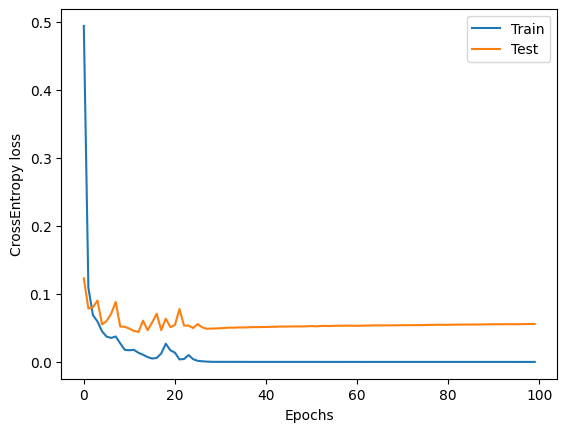

In [50]:
import matplotlib.pyplot as plt

plt.plot(mlp.train_loss_, label="Train")
if len(mlp.test_loss_) > 0:
    plt.plot(mlp.test_loss_, label="Test")
plt.xlabel("Epochs")
plt.ylabel("CrossEntropy loss")
plt.legend()
plt.show()


In [51]:
from sklearn.neural_network import MLPClassifier as SK_MLPClassifier

clf = SK_MLPClassifier(hidden_layer_sizes=(256, 128), activation="relu", max_iter=100, alpha=0.0001, batch_size=128, learning_rate_init=0.005, solver='adam', momentum=0.9,random_state=42)
fit_sklearn_model(clf, X_train, y_train, X_test, y_test)

Train accuracy: 1.0
Test Accuracy: 0.9830097087378641

Classification Report:
                precision    recall       f1-score     support     
-----------------------------------------------------------------
1               0.9973       0.9973       0.9973       369         
2               0.9889       0.9926       0.9908       270         
3               0.9930       0.9930       0.9930       284         
4               0.9651       0.9549       0.9600       377         
5               0.9552       0.9633       0.9592       354         
6               1.0000       1.0000       1.0000       406         
-----------------------------------------------------------------
macro avg       0.9833       0.9835       0.9834       2060        
weighted avg    0.9830       0.9830       0.9830       2060        
-----------------------------------------------------------------
accuracy        0.9830       2060        



## One-vs-Rest SVM (OVR-SVM)

In the lab, the problem was binary classification. Here we use the One-vs-Rest approach:
- We train one SVM for each class
- For each SVM, the positive class is the active class (+1) and all others are negative (-1)
- The final label is the label of the SVM with the highest score

In [52]:
class SVM(BaseModel):

    def __init__(self, lr=0.01, epochs=10, lam=1e-4, seed=42):
        self.lr = lr
        self.epochs = epochs
        self.lam = lam
        self.seed = seed
        self.W = None
        self.b = None
        self.classes = None

    def fit(self, X_train, y_train):
        X = np.asarray(X_train, dtype=float)
        y = np.asarray(y_train)

        self.classes = np.unique(y)
        Ws = []
        bs = []

        for idx, c in enumerate(self.classes):
            y_pm1 = np.where(y == c, 1.0, -1.0)
            w, b = self._fit_linear_svm_sgd(X, y_pm1, seed=self.seed + idx)
            Ws.append(w)
            bs.append(b)

        self.W = np.vstack(Ws)
        self.b = np.array(bs, dtype=float)
        return self

    def _fit_linear_svm_sgd(self, X, y_pm1, seed):
        n, d = X.shape
        rng = np.random.default_rng(seed)
        w = np.zeros(d, dtype=float)
        b = 0.0

        for epoch in range(self.epochs):
            perm = rng.permutation(n)
            for i in perm:
                xi = X[i]
                yi = y_pm1[i]
                margin = yi * (xi @ w + b)

                if margin >= 1.0:
                    w -= self.lr * (self.lam * w)
                else:
                    w -= self.lr * (self.lam * w - yi * xi)
                    b -= self.lr * (-yi)

        return w, b

    def predict(self, X):
        X = np.asarray(X, dtype=float)
        scores = X @ self.W.T + self.b
        pred_idx = np.argmax(scores, axis=1)
        return self.classes[pred_idx]


In [53]:
model = SVM(lr=0.01, epochs=10, lam=1e-4, seed=42)
model.fit(X_train, y_train)

y_pred_test = model.predict(X_test)
y_pred_train = model.predict(X_train)

acc_train = (y_pred_train == np.asarray(y_train)).mean()
acc_test = (y_pred_test == np.asarray(y_test)).mean()
print("Train accuracy:" ,  acc_train)
print("Test Accuracy:", acc_test)
print("\nClassification Report:")
print_classification_report(y_test, y_pred_test)


Train accuracy: 0.9717198689161306
Test Accuracy: 0.962135922330097

Classification Report:
                precision    recall       f1-score     support     
-----------------------------------------------------------------
1               0.9946       1.0000       0.9973       369         
2               0.9926       0.9889       0.9907       270         
3               0.9965       0.9965       0.9965       284         
4               0.8451       0.9841       0.9093       377         
5               0.9828       0.8079       0.8868       354         
6               1.0000       1.0000       1.0000       406         
-----------------------------------------------------------------
macro avg       0.9686       0.9629       0.9634       2060        
weighted avg    0.9663       0.9621       0.9618       2060        
-----------------------------------------------------------------
accuracy        0.9621       2060        



In [54]:
from sklearn.svm import LinearSVC as SK_LinearSVC
fit_sklearn_model(SK_LinearSVC(C=1e-2), X_train, y_train, X_test, y_test)

Train accuracy: 0.9871343609661367
Test Accuracy: 0.9810679611650486

Classification Report:
                precision    recall       f1-score     support     
-----------------------------------------------------------------
1               0.9973       0.9973       0.9973       369         
2               0.9926       0.9963       0.9945       270         
3               0.9965       1.0000       0.9982       284         
4               0.9521       0.9496       0.9509       377         
5               0.9518       0.9492       0.9505       354         
6               1.0000       1.0000       1.0000       406         
-----------------------------------------------------------------
macro avg       0.9817       0.9821       0.9819       2060        
weighted avg    0.9810       0.9811       0.9810       2060        
-----------------------------------------------------------------
accuracy        0.9811       2060        



## K-Means Clustering

In [55]:
class KMeans(BaseModel):

    def __init__(self, k, max_iters=100, seed=42):
        self.k = k
        self.max_iters = max_iters
        self.seed = seed
        self.centroids = None

    def fit(self, X_train, y_train=None):
        X = np.asarray(X_train, dtype=float)
        n, d = X.shape
        rng = np.random.default_rng(self.seed)

        idx = rng.choice(n, size=self.k, replace=False)
        self.centroids = X[idx].copy()

        labels = np.zeros(n, dtype=int)

        for it in range(self.max_iters):
            x_norm = np.sum(X**2, axis=1, keepdims=True)
            c_norm = np.sum(self.centroids**2, axis=1, keepdims=True).T
            d2 = x_norm + c_norm - 2 * (X @ self.centroids.T)
            d2 = np.maximum(d2, 0.0)

            new_labels = np.argmin(d2, axis=1)

            if np.array_equal(new_labels, labels) and it > 0:
                break
            labels = new_labels

            for j in range(self.k):
                pts = X[labels == j]
                if pts.shape[0] > 0:
                    self.centroids[j] = pts.mean(axis=0)
                else:
                    self.centroids[j] = X[rng.integers(0, n)]

        return self

    def predict(self, X):
        X = np.asarray(X, dtype=float)
        x_norm = np.sum(X**2, axis=1, keepdims=True)
        c_norm = np.sum(self.centroids**2, axis=1, keepdims=True).T
        d2 = x_norm + c_norm - 2 * (X @ self.centroids.T)
        d2 = np.maximum(d2, 0.0)

        return np.argmin(d2, axis=1)


Cluster → label mapping: {np.int64(0): '2', np.int64(1): '5', np.int64(2): '3', np.int64(3): '1', np.int64(4): '6', np.int64(5): '3'}
K-means clustering accuracy (test): 0.4947
K-means clustering accuracy (train): 0.4996
Number of clusters: 6
Clusters found: [0 1 2 3 4 5]
Explained variance (PC1+PC2): 319.874


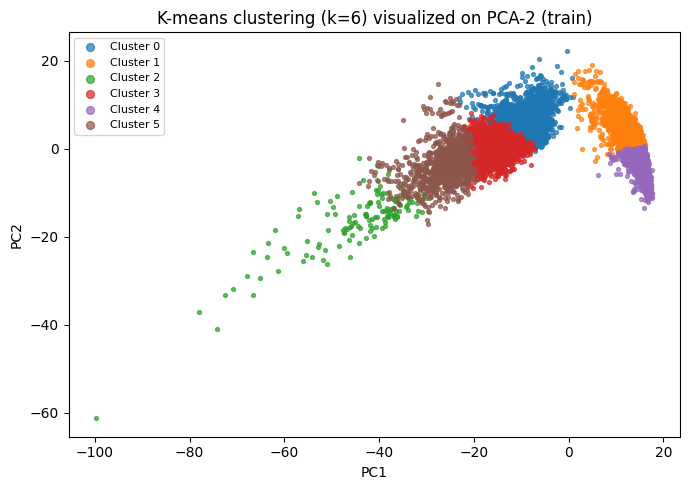

In [59]:
from collections import Counter

k_clusters = len(np.unique(y_train))
model = KMeans(k=k_clusters, max_iters=100, seed=42)
model.fit(X_train, y_train=None)

clabels_train = model.predict(X_train)
y_train_np = np.asarray(y_train)

cluster_to_label = {}
correct = 0

for c in np.unique(clabels_train):
    idx = (clabels_train == c)
    true_labels = y_train_np[idx]

    if len(true_labels) == 0:
        continue

    most_common_label = Counter(true_labels).most_common(1)[0][0]
    cluster_to_label[c] = most_common_label

    correct += np.sum(true_labels == most_common_label)

train_accuracy = correct / len(y_train_np)

clabels_test = model.predict(X_test)
y_test_np = np.asarray(y_test)

correct_test = 0

for c in np.unique(clabels_test):
    idx = (clabels_test == c)

    assigned_label = cluster_to_label[c]
    correct_test += np.sum(y_test_np[idx] == assigned_label)

accuracy_test = correct_test / len(y_test_np)


print("Cluster → label mapping:", cluster_to_label)
print(f"K-means clustering accuracy (test): {accuracy_test:.4f}")
print(f"K-means clustering accuracy (train): {train_accuracy:.4f}")

pca2 = PCA(n_components=2)
pca2.fit(X_train)
Ttr2 = pca2.predict(X_train)
Ttr2_np = np.asarray(Ttr2)

print(f"Number of clusters: {k_clusters}")
print(f"Clusters found: {np.unique(clabels_train)}")
print(f"Explained variance (PC1+PC2): {pca2.explained_variance_.sum():.3f}")

import matplotlib.pyplot as plt

plt.figure(figsize=(7, 5))
for c in range(k_clusters):
    idx = (clabels_train == c)
    plt.scatter(Ttr2_np[idx, 0], Ttr2_np[idx, 1], s=8, alpha=0.7, label=f"Cluster {c}")

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title(f"K-means clustering (k={k_clusters}) visualized on PCA-2 (train)")
plt.legend(markerscale=2, fontsize=8)
plt.tight_layout()
plt.show()


Cluster → label mapping: {np.int32(0): '5', np.int32(1): '2', np.int32(2): '5', np.int32(3): '3', np.int32(4): '6', np.int32(5): '3'}
K-means clustering accuracy (test): 0.5398
K-means clustering accuracy (train): 0.5685
Number of clusters: 6
Clusters found: [0 1 2 3 4 5]
Explained variance (PC1+PC2): 319.874


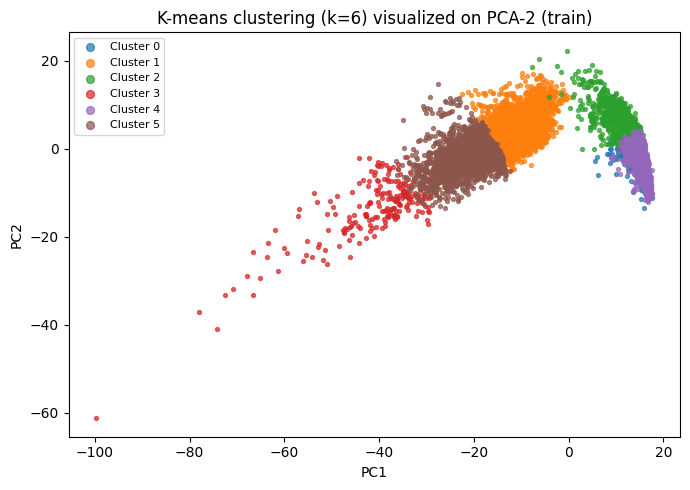

In [60]:
from sklearn.cluster import KMeans as SK_KMeans

model = SK_KMeans(n_clusters=k_clusters, max_iter=100, random_state=42)
model.fit(X_train)

clabels_train = model.predict(X_train)
y_train_np = np.asarray(y_train)

cluster_to_label = {}
correct = 0

for c in np.unique(clabels_train):
    idx = (clabels_train == c)
    true_labels = y_train_np[idx]

    if len(true_labels) == 0:
        continue

    most_common_label = Counter(true_labels).most_common(1)[0][0]
    cluster_to_label[c] = most_common_label

    correct += np.sum(true_labels == most_common_label)

train_accuracy = correct / len(y_train_np)

clabels_test = model.predict(X_test)
y_test_np = np.asarray(y_test)

correct_test = 0

for c in np.unique(clabels_test):
    idx = (clabels_test == c)

    assigned_label = cluster_to_label[c]
    correct_test += np.sum(y_test_np[idx] == assigned_label)

accuracy_test = correct_test / len(y_test_np)


print("Cluster → label mapping:", cluster_to_label)
print(f"K-means clustering accuracy (test): {accuracy_test:.4f}")
print(f"K-means clustering accuracy (train): {train_accuracy:.4f}")

pca2 = PCA(n_components=2)
pca2.fit(X_train)
Ttr2 = pca2.predict(X_train)
Ttr2_np = np.asarray(Ttr2)

print(f"Number of clusters: {k_clusters}")
print(f"Clusters found: {np.unique(clabels_train)}")
print(f"Explained variance (PC1+PC2): {pca2.explained_variance_.sum():.3f}")

import matplotlib.pyplot as plt

plt.figure(figsize=(7, 5))
for c in range(k_clusters):
    idx = (clabels_train == c)
    plt.scatter(Ttr2_np[idx, 0], Ttr2_np[idx, 1], s=8, alpha=0.7, label=f"Cluster {c}")

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title(f"K-means clustering (k={k_clusters}) visualized on PCA-2 (train)")
plt.legend(markerscale=2, fontsize=8)
plt.tight_layout()
plt.show()
